# Setup notebook for experiment

Setting up the workspace - assuming:  
you've vscode  (setup with python, jupyter and anaconda) - just my preferred dev env  
have cloned the repo  
are in the parent folder called sandbox  
and have created a conda environment in which you're running this notebook  

In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

## Imports

In [2]:
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
from src.plotting_func import *
from src.strategies import *
from src.utils import *

# Set up Network

watts_strogatz_graph - mimics social networks  
https://www.kth.se/social/files/5605669af2765468be471eda/lecture%204%20%282015%29.pdf  
https://snap.stanford.edu/class/cs224w-readings/watts98smallworld.pdf  
agents - nodes - people /regions  
create a graph with n nodes and k nearest neighbors with p probability of rewiring (long range connections)  

 
n ~30 for testing, k ~ n/10 (even, > 2 for clusters), p=0.3 introduces global connections  
refer to notebook sandbox_social_networks for more details  

In [4]:
def generate_graph(num_nodes=50, k=6, p=0.3):
    G = nx.watts_strogatz_graph(n=num_nodes, k=k, p=p)
    return G

G = generate_graph()

Each node has two options - to defect (0) or to cooperate (1) - its not a value more like option A and option B  
this information is captured in a node's current state - this represents the action (not the value of that action) 
Value of decisions is assigned further below in payoffs

# Simple Initialization

Simple here means nodes are randomly initialized  
and all of them have same strategy (which in a way is learning from their neighbors to maximize the reward)  

In [5]:
def initialize_actions(G, random_init=True): #all nodes randomly initialized
    for node in G.nodes:
        G.nodes[node]['current_action'] = np.random.choice([0, 1]) if random_init else 1
        
initialize_actions(G)

Displaying this network here - you could change n,k and p above if you're not satisfied with this one or want to model something else  
you can also refer to other sandbox notebook on social networks i have created to see some other samples and play around with more model environments you would like to experiment with  


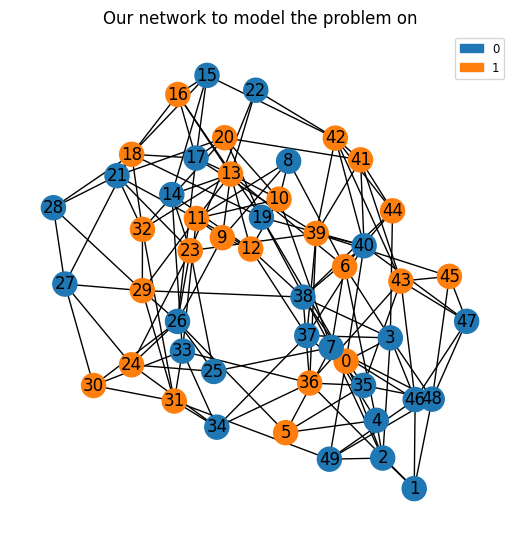

In [6]:
current_actions = [G.nodes[node]['current_action'] for node in G.nodes]
visualize_graph(G, current_actions, title="Our network to model the problem on")

where its initialized with some people defecting (0) and some cooperating (1) - this can be changed later - but for now we just choose to initialize them like this

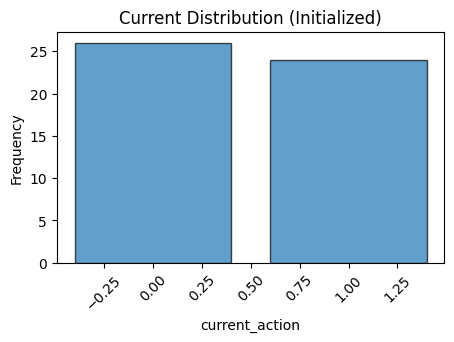

In [7]:
plot_node_attribute_dist(G.nodes, 'current_action', title="Current Distribution (Initialized)")

# Rules

Setting rewards and penalties - its a cooperation game between 2 - so rewards and penalties are on 2^2 => 4 combinations  
We want to reward cooperation most  
i was however thinking that we could also add something for whoever defects after gets more that'd be interesting but maybe later  


In [8]:
payoff_matrix = {
    (1, 1): (3, 3),  # Both cooperate
    (1, 0): (0, 2),  # Cooperator gets 0, defector gets 2
    (0, 1): (2, 0),  # Defector gets 2, cooperator gets 0
    (0, 0): (0, 0)   # Both defect
}

Right now no node has any payoff assigned because we have initialized them but we havent done message passing yet

# Round - Interaction

This defines one round of prisoners dilemma  
our graph has already been initialized to cooperating and defecting nodes  
we start with setting the payoffs for everyone to 0  
we take their initialized actions  
calculate the payoffs for each node based on its interaction with its neighbors  
assign payoff to each node  

In [9]:
def play_pd_round(G):
    payoffs = {node: 0 for node in G.nodes} #initializing payoff for each to 0
    for node in G.nodes: #each node can only play with its neighbors which in our case was defined by k
        for neighbor in G.neighbors(node): # for each neighbor
            s1 = G.nodes[node]['current_action']  # we get action of the node
            s2 = G.nodes[neighbor]['current_action'] # we get action of the neighbor
            p1, p2 = payoff_matrix[(s1, s2)] # we calculate payoff of each interaction - where p1 is payoff of node in question
            payoffs[node] += p1 #adding the payoff of the node in question (based on interaction with all its neighbors)
        G.nodes[node]['payoff'] = payoffs[node] #updating the node with its payoff

In [10]:
play_pd_round(G)
print("Payoffs:", [G.nodes[node]['payoff'] for node in G.nodes])

Payoffs: [0, 2, 2, 6, 4, 0, 6, 6, 8, 9, 12, 15, 12, 21, 6, 6, 6, 10, 6, 8, 9, 10, 6, 6, 3, 4, 12, 8, 4, 9, 3, 9, 15, 8, 6, 6, 6, 4, 8, 15, 8, 15, 12, 12, 9, 6, 2, 4, 2, 4]


Now each node has payoff - right now it was a mix of luck (cause it was randomly initialized to have defecting or cooperating neighbors)  
and its own decisions (some of them were nice (cooperative) - some of them were nasty (defecting))  
the nodes are also initialized to be nice or nasty randomly - so we've about 50% nice and 50% nasty in our sample of 50 

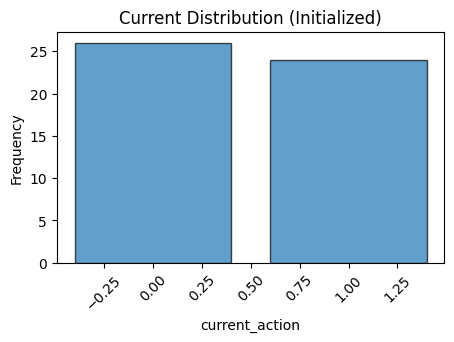

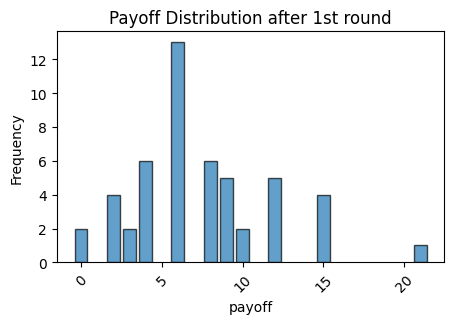

In [11]:
plot_node_attribute_dist(G.nodes, 'current_action', title="Current Distribution (Initialized)")
plot_node_attribute_dist(G.nodes, 'payoff', title="Payoff Distribution after 1st round")

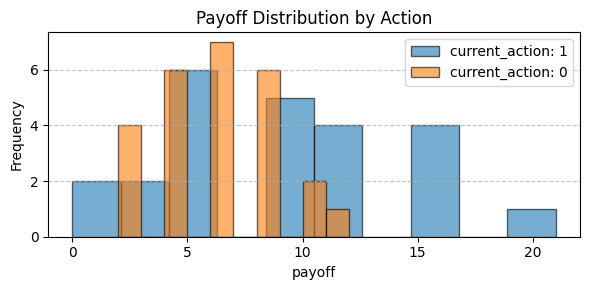

In [12]:
plot_node_attribute_grouped_dist(G, group_by='current_action', value_attr='payoff', 
                            title="Payoff Distribution by Action")


in this particular instance:  
This graph shows us that high payoffs (>10) - are only obtained by nodes with cooperation strategy - that is nodes that were initialized as 1s 
this also shows that the lowest payoff is also a cooperative node and most of the defectors were in the middle

what we should look for is the peak of the blue and orange distributions - where they lie  
on the payoff scale - are the peak of distribution towards the right (most of theme have high payoff)
on the frequency scale - is the peak higher (smoother distribution or not - a not smooth distribution indicates that most of them are likely to have that payoff value)

# Updating action after interaction

Each neighbor mimics the neighbor with highest payoff in the last round

In [13]:
def update_actions(G):
    for node in G.nodes:
        payoffs = {n: G.nodes[n]['payoff'] for n in G.neighbors(node)}
        neighbor_payoffs = {neighbor: payoffs[neighbor] for neighbor in G.neighbors(node)}
        if neighbor_payoffs:
            best_neighbor = max(neighbor_payoffs, key=neighbor_payoffs.get)
            G.nodes[node]['current_action'] = G.nodes[best_neighbor]['current_action']

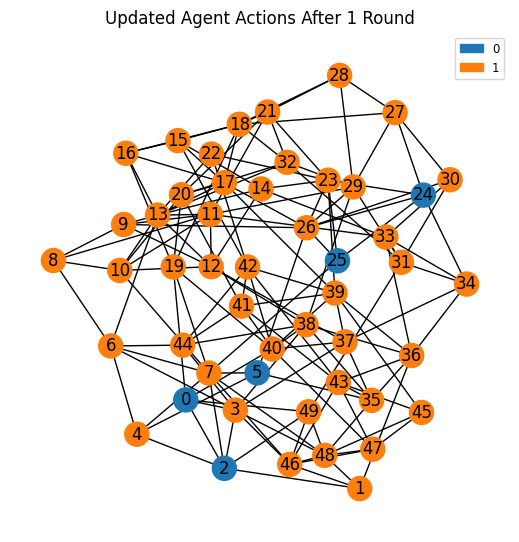

In [14]:
update_actions(G)
current_actions2 = [G.nodes[node]['current_action'] for node in G.nodes]
visualize_graph(G, current_actions2, title="Updated Agent Actions After 1 Round")

Well i guess cooperation works - most of the agents realized that lol - niceness spreads fast! (i might run it multiple times and that might not be the case)

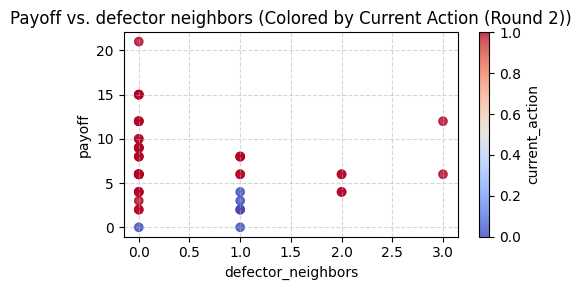

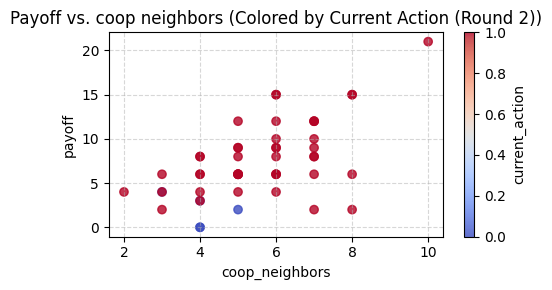

In [15]:
def compute_neighbor_counts(G):
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        neighbor_actions = [G.nodes[neighbor]['current_action'] for neighbor in neighbors]
        G.nodes[node]['defector_neighbors'] = neighbor_actions.count(0)
        G.nodes[node]['coop_neighbors'] = neighbor_actions.count(1)
compute_neighbor_counts(G)
plot_node_scatter(G, x_attr='defector_neighbors', y_attr='payoff', color_attr='current_action', 
                  title="Payoff vs. defector neighbors (Colored by Current Action (Round 2))")
plot_node_scatter(G, x_attr='coop_neighbors', y_attr='payoff', color_attr='current_action', 
                  title="Payoff vs. coop neighbors (Colored by Current Action (Round 2))")

# Multiple strategies

above we just randomly initialized and planned to use mimic down the road to dictate the next decision - mimic or imitator in this case just copies the move of its highest paid neighbor  

if you watched the youtube video you see they have a lot of actors / agents / strategies their like tit-for-tat etc.  
i (with the help of chatgpt) have written some of those out in there - 
now the method below actually has another initialization option - in which each of your node has an actual strategy and wont be all mimicing down the road  

In [16]:
def initialize_agent_actions(G, config=None, random_init=True):
    for node in G.nodes:
        G.nodes[node]['strategy_type'] = config['strategy_type'] if config and 'strategy_type' in config else np.random.choice(list(STRATEGY_FUNCTIONS.keys()))
        G.nodes[node]['current_action'] = np.random.choice([0, 1]) if random_init else 1
        G.nodes[node]['memory'] = {}
        G.nodes[node]['triggered'] = False
        G.nodes[node]['payoff'] = 0
        G.nodes[node]['prev_payoff'] = 0

In [17]:
def initialize_agent_actions(G, config=None, random_init=True):
    strategy_types = list(STRATEGY_FUNCTIONS.keys())
    nodes = list(G.nodes)
    total_nodes = len(nodes)

    if config:
        strategy_counts = []
        assigned_nodes = 0
        for strategy in config:
            count = int(config[strategy] * total_nodes)
            strategy_counts.append((strategy, count))
            assigned_nodes += count
        remaining_nodes = total_nodes - assigned_nodes
        # If there are remaining nodes, assign them randomly
        remaining_strategies = np.random.choice(strategy_types, size=remaining_nodes)

        strategy_assignment = []
        for strategy, count in strategy_counts:
            strategy_assignment.extend([strategy] * count)
        strategy_assignment.extend(remaining_strategies)
        
        # Shuffle the assignments
        strategy_assignment = np.array(strategy_assignment)
        np.random.shuffle(strategy_assignment)
    else:
        # Assign all nodes randomly
        strategy_assignment = np.random.choice(strategy_types, size=total_nodes)

    # Assign strategies and initialize other attributes
    for node, strategy in zip(nodes, strategy_assignment):
        G.nodes[node]['strategy_type'] = strategy
        G.nodes[node]['current_action'] = np.random.choice([0, 1]) if random_init else 1
        G.nodes[node]['memory'] = {}
        G.nodes[node]['triggered'] = False
        G.nodes[node]['payoff'] = 0
        G.nodes[node]['prev_payoff'] = 0


In [18]:
initialize_agent_actions(G)

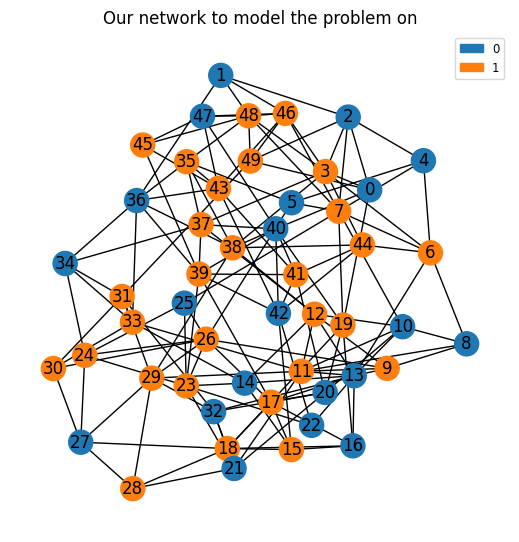

In [19]:
current_actions = [G.nodes[node]['current_action'] for node in G.nodes]
visualize_graph(G, current_actions, title="Our network to model the problem on")

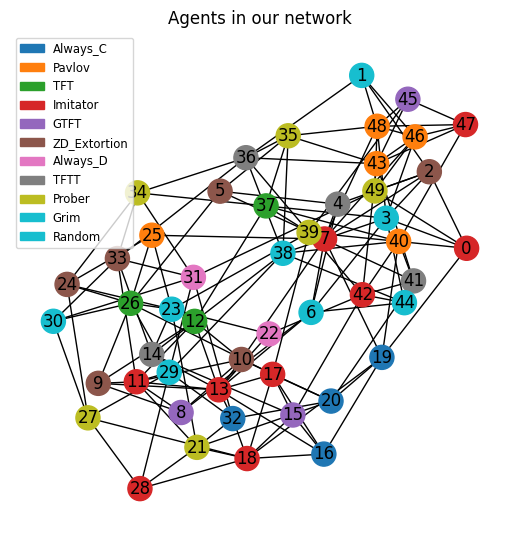

In [20]:
agent_strategies = [G.nodes[node]['strategy_type'] for node in G.nodes]
visualize_graph(G, agent_strategies, title="Agents in our network")

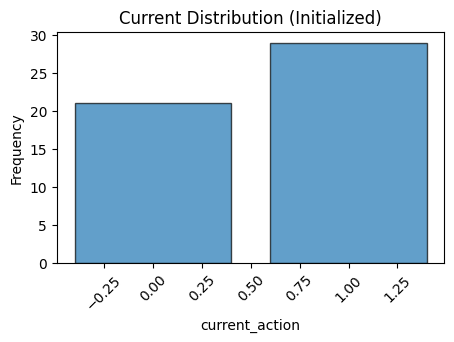

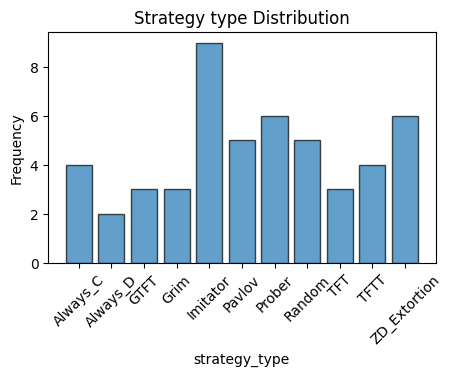

In [21]:
plot_node_attribute_dist(G.nodes, 'current_action', title="Current Distribution (Initialized)")
plot_node_attribute_dist(G.nodes, 'strategy_type', title="Strategy type Distribution")

so, starting the round again on this new graph - doing interactions - calculating payoffs - this shouldn't be any different than the first time because we still have initialized the nodes randomly and again payoffs is luck - much like real life these actors will be advantaged or disadvantaged (because they could be always cooperate but initialized to defect)

In [22]:
play_pd_round(G)

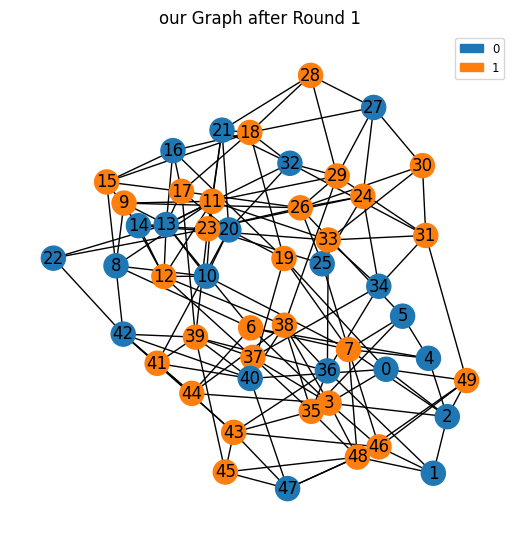

In [23]:
current_actions2 = [G.nodes[node]['current_action'] for node in G.nodes]
visualize_graph(G, current_actions2, title="our Graph after Round 1")

# Updating action - after interaction

In [24]:
def update_agent_actions(G):             
    for node in G.nodes:
        # payoffs = {n: G.nodes[n]['payoff'] for n in G.neighbors(node)}
        strategy_type = G.nodes[node]['strategy_type']
        strategy_func = STRATEGY_FUNCTIONS[strategy_type]
        neighbors = list(G.neighbors(node))
        next_action = strategy_func(node, G, neighbors)
        G.nodes[node]['current_action'] = next_action
        G.nodes[node]['prev_payoff'] = G.nodes[node]['payoff']
        for neighbor in neighbors:
            G.nodes[node]['memory'][neighbor] = G.nodes[neighbor]['current_action']

the above code is the one that'll be making things interesting thing because now instead of mimicing the behaviour of their most well performing neighbor - they'll act according to their own characterstics  

In [25]:
update_agent_actions(G)

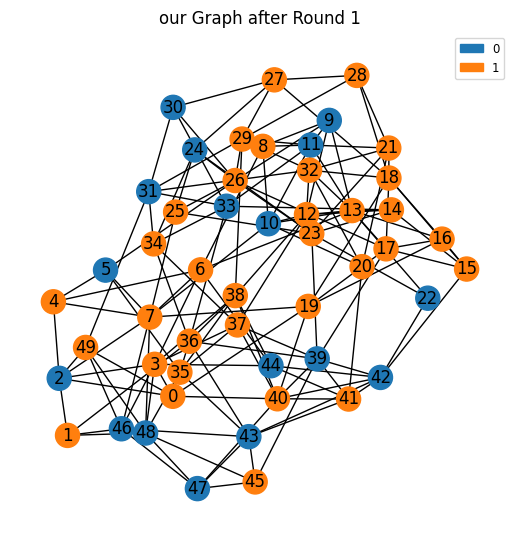

In [26]:
current_actions2 = [G.nodes[node]['current_action'] for node in G.nodes]
visualize_graph(G, current_actions2, title="our Graph after Round 1")

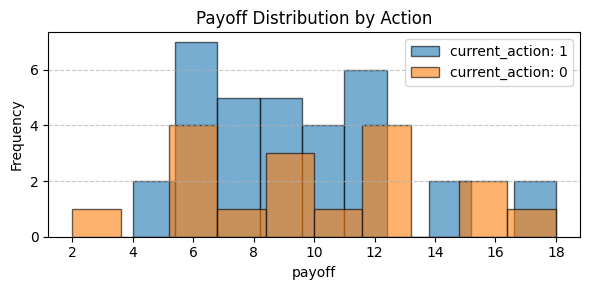

In [27]:
plot_node_attribute_grouped_dist(G, group_by='current_action', value_attr='payoff', title="Payoff Distribution by Action")

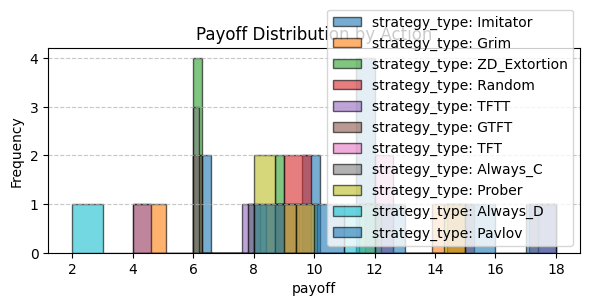

In [28]:
plot_node_attribute_grouped_dist(G, group_by='strategy_type', value_attr='payoff', title="Payoff Distribution by Action")

Okay that sjust initial round - thats what we start with  
we didnt start with all cooperate - equal footing payoffs 0  
we let first payoff decided by the neighbors (coop or def) and their own behaviour was randomly initialized  

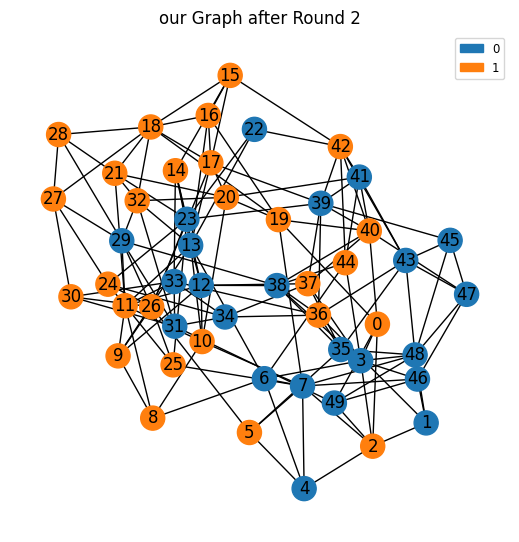

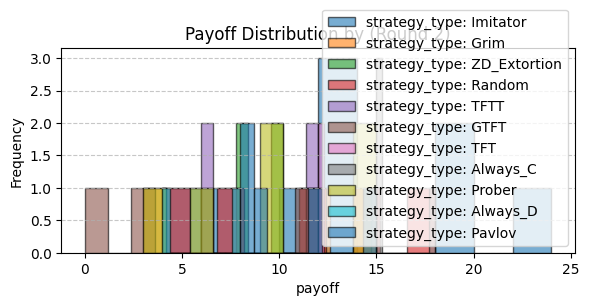

In [29]:
play_pd_round(G)
update_agent_actions(G)
current_actions3 = [G.nodes[node]['current_action'] for node in G.nodes]    
visualize_graph(G, current_actions3, title="our Graph after Round 2")
plot_node_attribute_grouped_dist(G, group_by='strategy_type', value_attr='payoff', title="Payoff Distribution by (Round 2)")

In [30]:
analyze_strategy_performance(G)

Strategy       Avg Payoff  Min Payoff  Max Payoff  Total Payoff   Node Count
Always_C       15.75       15.00       18.00       63.00          4         
TFT            13.00       12.00       15.00       39.00          3         
Imitator       12.89       4.00        24.00       116.00         9         
Random         11.40       4.00        18.00       57.00          5         
Pavlov         10.40       8.00        15.00       52.00          5         
Grim           10.00       3.00        15.00       30.00          3         
Prober         9.33        3.00        15.00       56.00          6         
ZD_Extortion   9.00        6.00        12.00       54.00          6         
TFTT           9.00        6.00        12.00       36.00          4         
Always_D       6.00        4.00        8.00        12.00          2         
GTFT           5.00        0.00        12.00       15.00          3         


# Run for multiple rounds

Now that we have defined the steps - we will create a new graph - call those methods and run multiple rounds - and store each round 

In [31]:
def run_simulation(G, num_rounds=10):

    G = generate_graph(num_nodes=50, k=6, p=0.3)
    # initialize_actions(G, random=False)
    initialize_agent_actions(G, config=load_config(), random_init=True)
    
    current_actions = [G.nodes[node]['current_action'] for node in G.nodes]
    visualize_graph(G, current_actions, title="Our network to model the problem on (Initialized)")
    plot_node_attribute_dist(G.nodes, 'current_action', title="Current Distribution (Initialized)")
    
    all_data = []

    for round_num in range(num_rounds): # In every round
        # Calculate payoffs
        play_pd_round(G)
        # Collect node features and labels
        for node in G.nodes:
            degree = G.degree[node]
            current_action = G.nodes[node]['current_action']
            strategy_type = G.nodes[node]['strategy_type']
            payoffs = G.nodes[node]['payoff']
            prev_payoff = G.nodes[node]['prev_payoff']
            memory = G.nodes[node]['memory']
            triggered = G.nodes[node]['triggered']
            neighbors = list(G.neighbors(node))
            neighbor_actions = [G.nodes[neighbor]['current_action'] for neighbor in neighbors]
            defector_neighbors = neighbor_actions.count(0)
            coop_neighbors = neighbor_actions.count(1)
            all_data.append({
                'node': node,
                'round': round_num,
                'degree': degree,
                'current_action': current_action,
                'strategy_type': strategy_type,
                'payoff': payoffs,
                'memory': memory,
                'current_action': current_action,
                'memory': memory,
                'triggered': triggered,
                'prev_payoff': prev_payoff,
                'coop_neighbors': coop_neighbors,
                'defector_neighbors': defector_neighbors
            })
        # Update actions based on payoffs
        update_actions(G)
        # update_agent_actions(G)
        # Visualize the graph after each round  

        current_actions = [G.nodes[node]['current_action'] for node in G.nodes]

        visualize_graph(G, current_actions, title=f"Graph after Round {round_num + 1}")
        
        plot_node_attribute_dist(G.nodes, 'current_action', title=f"Current Distribution (Round {round_num + 1})")
        plot_node_attribute_grouped_dist(G, group_by='current_action', value_attr='payoff', 
                            title=f"Payoff Distribution by Action (Round {round_num + 1})")
        plot_node_attribute_grouped_dist(G, group_by='strategy_type', value_attr='payoff', 
                            title=f"Payoff Distribution by Strategy (Round {round_num + 1})")
        # plot_node_scatter(G, x_attr='defector_neighbors', y_attr='payoff', color_attr='current_action', 
        #           title=f"Payoff vs. defector neighbors (Colored by Current Action (Round {round_num + 1}))")
        # plot_node_scatter(G, x_attr='coop_neighbors', y_attr='payoff', color_attr='current_action', 
        #           title=f"Payoff vs. coop neighbors (Colored by Current Action (Round {round_num + 1}))")
        # plot_node_scatter(G, x_attr='coop_neighbors', y_attr='payoff', color_attr='strategy_type', 
        #           title=f"Payoff vs. coop neighbors (Colored by Strategy Type (Round {round_num + 1}))")
        # plot_node_scatter(G, x_attr='defector_neighbors', y_attr='payoff', color_attr='strategy_type', 
        #           title=f"Payoff vs. defector neighbors (Colored by Strategy Type (Round {round_num + 1}))")
        # plot_node_scatter(G, x_attr='coop_neighbors', y_attr='payoff', color_attr='coop_neighbors', 
        #           title=f"Payoff vs. coop neighbors (Colored by Coop Neighbors (Round {round_num + 1}))")
        # plot_node_scatter(G, x_attr='defector_neighbors', y_attr='payoff', color_attr='defector_neighbors', 
        #           title=f"Payoff vs. defector neighbors (Colored by Defector Neighbors (Round {round_num + 1}))")   

    return pd.DataFrame(all_data)

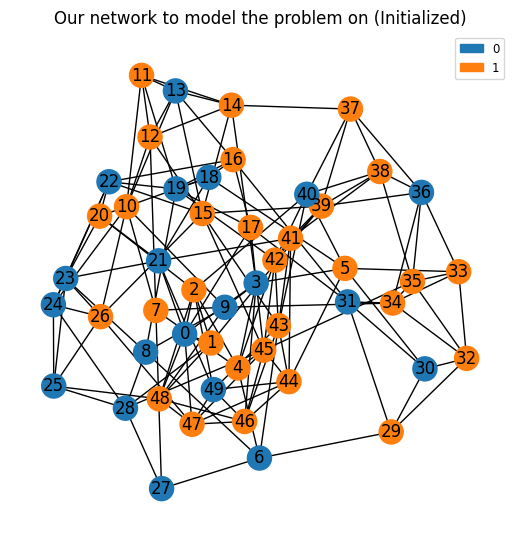

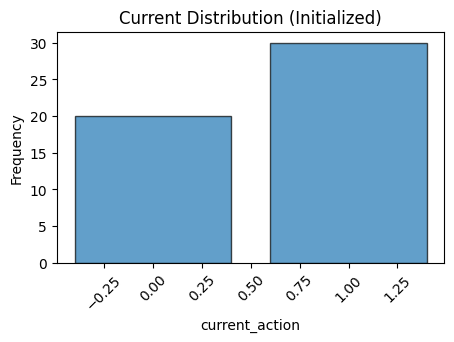

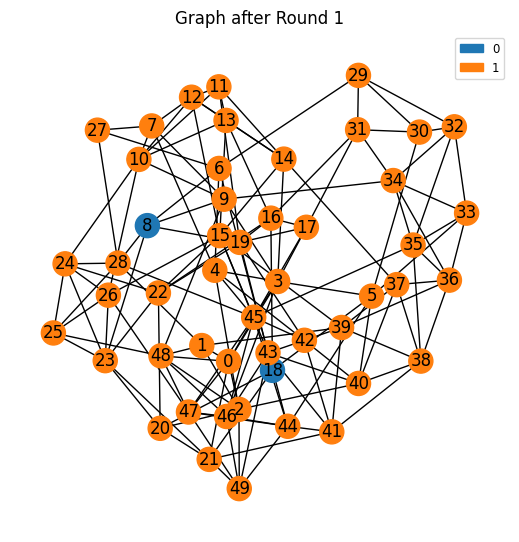

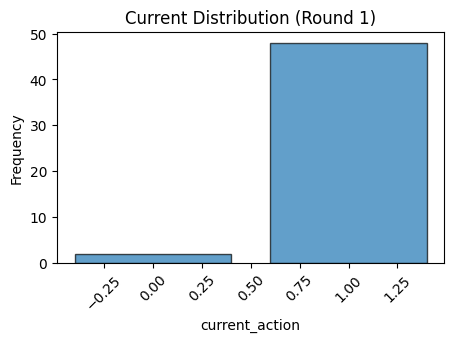

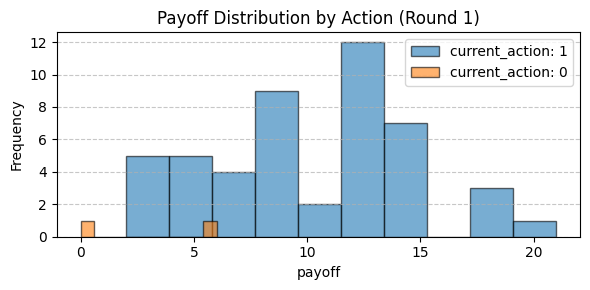

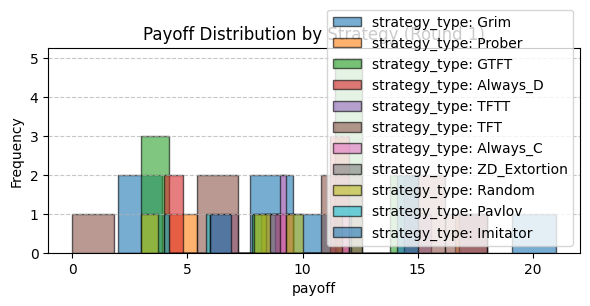

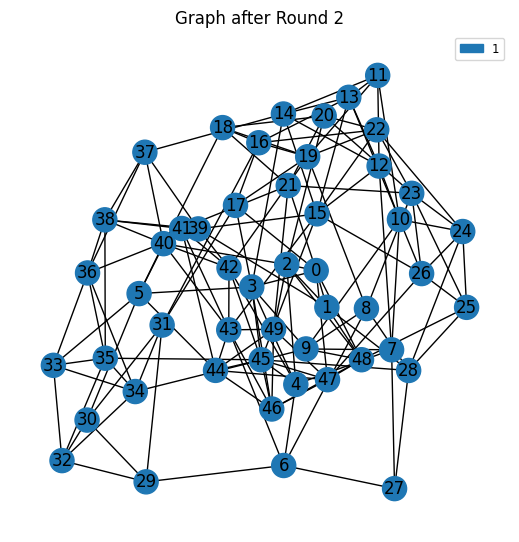

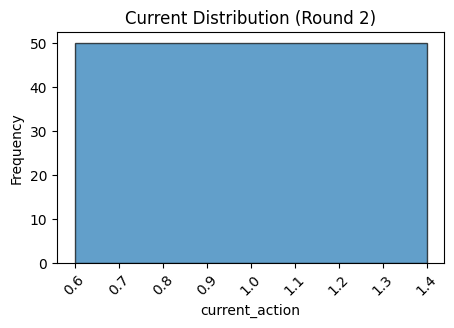

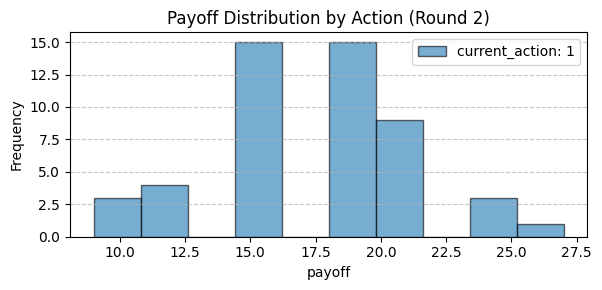

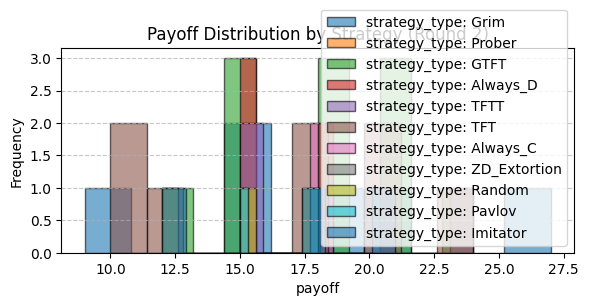

,node,round,degree,current_action,strategy_type,payoff,memory,triggered,prev_payoff,coop_neighbors,defector_neighbors
0,0,0,7,0,Grim,10,{},False,0,5,2
1,1,0,5,1,Prober,9,{},False,0,3,2
2,2,0,7,1,GTFT,12,{},False,0,4,3
3,3,0,8,0,GTFT,12,{},False,0,6,2
4,4,0,6,1,Always_D,12,{},False,0,4,2


In [32]:
df = run_simulation(G, num_rounds=2)
df.to_csv('../data/agent_simulation2.csv', index=False)
df.head(5)